# Bidirectional Encoder Representations from Transformers (BERT)





In [1]:
!pip -q install transformers

In [2]:
import torch
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
import re
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold
from transformers import BertTokenizer
from transformers import BertForSequenceClassification, AdamW, BertConfig
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
import torch.nn.functional as F

import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
from torch.utils.data.sampler import SubsetRandomSampler
import transformers
from transformers import RobertaTokenizer, BertTokenizer, RobertaModel, BertModel, AdamW
from transformers import get_linear_schedule_with_warmup
import time
from sklearn.metrics import roc_auc_score, classification_report, plot_confusion_matrix, confusion_matrix

import warnings
warnings.filterwarnings("ignore")
import tqdm
import seaborn as sns
import matplotlib.pyplot as plt


BERT_MODEL_NAME = 'neuralmind/bert-base-portuguese-cased'
# BERT_MODEL_NAME = 'neuralmind/bert-large-portuguese-cased'


class BertClassificationModel(nn.Module):
    def __init__(self):
        super(BertClassificationModel, self).__init__()
        self.bert_path = BERT_MODEL_NAME
        self.bert = transformers.BertModel.from_pretrained(self.bert_path)
        self.bert_drop=nn.Dropout(0.3)
        self.out = nn.Linear(768, 2)
        # self.out = nn.Linear(1024, 2)

    def forward(self, ids, mask):
        outputs = self.bert(input_ids=ids, attention_mask=mask)
        rh=self.bert_drop(outputs.pooler_output)
        return self.out(rh)


class CudaDevice:
    def get_device(self, force_cpu=False):
        if not force_cpu and torch.cuda.is_available():
            device = torch.device("cuda")
            print('Existe(m) %d GPU(s) disponíveis.' %
                  torch.cuda.device_count())
            print('A GPU', torch.cuda.get_device_name(0), 'será usada.')
        else:
            print('No GPU available, using the CPU instead.')
            device = torch.device("cpu")
        return device


class BertDataset(Dataset):

    def __init__(self,
                 data,
                 tokenizer,
                 max_len=None,
                 max_size_dataset=None,
                 ):
        self.tokenizer = tokenizer
        self.data_raw = data
        self.max_len = max_len
        self.max_size_dataset = max_size_dataset
        self.data, self.label = self.process_data()
        

    def process_data(self):
        
        print('Carregando os dados do dataset')
        df = self.data_raw.copy()

        if self.max_len:
            print(f'Limitando textos em {self.max_len} caracteres!')
            df['text'] = df['text'].apply(lambda x: x[:self.max_len] if len(x) > self.max_len else x)

        train = df.copy()

        if(self.max_size_dataset):
            print(f'Limitando dataset em {self.max_size_dataset} registros!')
            train = train.loc[0:self.max_size_dataset, :]
            
        train = train.reindex(np.random.permutation(train.index))
        train['text'] = train['text'].apply(self.clean_txt)
        return train['text'].values, train['label'].values

    def clean_txt(self, text):
        # text = re.sub("'", "", text)
        # text = re.sub("(\\W)+", " ", text)
        return text

    def __getitem__(self, idx):

        text = str(self.data[idx])
        target = int(self.label[idx])

        data = self.tokenizer.encode_plus(
            text,
            max_length=512,
            pad_to_max_length=True,
            add_special_tokens=True,
            return_attention_mask=True,
            return_token_type_ids=False,
            return_overflowing_tokens=False,
            truncation=True,
            return_tensors='pt')

        return({
            'ids': data['input_ids'].long(),
            'mask': data['attention_mask'].int(),
            'targets': torch.tensor([target], dtype=torch.int),
            'texto': text.strip(),
        })

    def __len__(self):
        
        """ Return data length """
        return self.label.shape[0]


def my_collate1(batches):
    return [{key: value for key, value in batch.items()} for batch in batches]


def loss_fun(outputs, targets):
    loss = nn.CrossEntropyLoss()
    return loss(outputs, targets)


def evaluate(target, predicted):
    
    true_label_mask = [1 if (np.argmax(x)-target[i]) ==
                       0 else 0 for i, x in enumerate(predicted)]
    nb_prediction = len(true_label_mask)
    true_prediction = sum(true_label_mask)
    false_prediction = nb_prediction-true_prediction
    accuracy = true_prediction/nb_prediction
    
    roc = roc_auc_score(target, predicted[:, 1])
    
    return{
        "accuracy": accuracy,
        "nb exemple": len(target),
        "true_prediction": true_prediction,
        "false_prediction": false_prediction,
        "roc_auc": roc
    }


def train_loop(data_loader, model, optimizer, device, scheduler=None):
    model.train()
    t0 = time.time()
    losses = []
    for batch_idx, batch in enumerate(data_loader):
        ids = [data["ids"] for data in batch]
        mask = [data["mask"] for data in batch]
        targets = [data["targets"] for data in batch]

        ids = torch.cat(ids)
        mask = torch.cat(mask)
        targets = torch.cat(targets)

        ids = ids.to(device, dtype=torch.long)
        mask = mask.to(device, dtype=torch.long)
        targets = targets.to(device, dtype=torch.long)

        optimizer.zero_grad()
        outputs = model(ids=ids, mask=mask)
        loss = loss_fun(outputs, targets)
        loss.backward()
        model.float()
        optimizer.step()
        if scheduler:
            scheduler.step()
        losses.append(loss.item())
        if batch_idx % 100 == 0:
            print(f"___ batch index = {batch_idx} / {len(data_loader)} ({100*batch_idx / len(data_loader):.2f}%), loss = {np.mean(losses[-10:]):.4f}, time = {time.time()-t0:.2f} seconds ___")
            t0 = time.time()
    return losses    


def eval_loop(data_loader, model, device):
    model.eval()
    fin_targets = []
    fin_outputs = []
    losses = []

    for batch_idx, batch in tqdm.tqdm(enumerate(data_loader)):
        ids = [data["ids"] for data in batch]
        mask = [data["mask"] for data in batch]
        targets = [data["targets"] for data in batch]

        ids = torch.cat(ids)
        mask = torch.cat(mask)
        targets = torch.cat(targets)

        ids = ids.to(device, dtype=torch.long)
        mask = mask.to(device, dtype=torch.long)
        targets = targets.to(device, dtype=torch.long)

        with torch.no_grad():
            outputs = model(ids=ids, mask=mask)
            loss = loss_fun(outputs, targets)
            losses.append(loss.item())

        fin_targets.append(targets.cpu().detach().numpy())
        fin_outputs.append(torch.softmax(outputs, dim=1).cpu().detach().numpy())

    return np.concatenate(fin_outputs), np.concatenate(fin_targets), losses    

########################################################################################
# variáveis globais
########################################################################################
device = CudaDevice().get_device(force_cpu=False)

TRAIN_BATCH_SIZE = 4
EPOCH = 3
validation_split = .2
shuffle_dataset = True
random_seed = 42
MAX_LEN = None
MAX_SIZE_DATASET = None


########################################################################################
# dataset
########################################################################################
train_raw = pd.read_csv('https://docs.google.com/uc?export=download&id=1_EKfnjomkWks4VqTMIpcEIb6nB5P0Xz2')
train_raw.columns = ['label','text']
train_raw['label'] = train_raw['label'].apply(lambda x: 1 if x == 'positivo' else 0)


########################################################################################
# se quiser trabalhar com amostra menor
########################################################################################
SAMPLE_SIZE = 1000
s_labels = train_raw['label'].value_counts(normalize=True).sort_index()
train_raw = pd.concat([
    train_raw[train_raw['label']==0].sample(int(SAMPLE_SIZE * s_labels[0]), random_state=random_seed), # ~0.427427
    train_raw[train_raw['label']==1].sample(int(SAMPLE_SIZE * s_labels[1]), random_state=random_seed), # ~0.572573
])

Existe(m) 1 GPU(s) disponíveis.
A GPU Tesla P100-PCIE-16GB será usada.


In [3]:
print('Loading BERT tokenizer...')

tokenizer = BertTokenizer.from_pretrained(BERT_MODEL_NAME)

X_train, X_test, y_train, y_test = train_test_split(
    train_raw[['text']], 
    train_raw.label, 
    test_size=0.3, 
    stratify=train_raw.label,
    random_state=random_seed
)

X_train, X_val, y_train, y_val = train_test_split(
    X_train[['text']], 
    y_train, 
    test_size=0.2, 
    stratify=y_train,
    random_state=random_seed
)

train_dataset = BertDataset(
    data=pd.concat([X_train, y_train], axis=1),
    tokenizer=tokenizer,
    max_len=MAX_LEN,
    max_size_dataset=MAX_SIZE_DATASET,
)

val_dataset = BertDataset(
    data=pd.concat([X_val, y_val], axis=1),
    tokenizer=tokenizer,
    max_len=MAX_LEN,
    max_size_dataset=MAX_SIZE_DATASET,
)

test_dataset = BertDataset(
    data=pd.concat([X_test, y_test], axis=1),
    tokenizer=tokenizer,
    max_len=MAX_LEN,
    max_size_dataset=MAX_SIZE_DATASET,
)

train_data_loader = DataLoader(
  train_dataset,
  batch_size=TRAIN_BATCH_SIZE,
  collate_fn=my_collate1
)

valid_data_loader = DataLoader(
  val_dataset,
  batch_size=TRAIN_BATCH_SIZE,
  collate_fn=my_collate1
)

test_data_loader = DataLoader(
  test_dataset,
  batch_size=TRAIN_BATCH_SIZE,
  collate_fn=my_collate1
)

lr=3e-5
num_training_steps=int(len(train_dataset) / TRAIN_BATCH_SIZE * EPOCH)

model=BertClassificationModel().to(device)
optimizer=AdamW(model.parameters(), lr=lr)
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                        num_warmup_steps = 0,
                                        num_training_steps = num_training_steps)
val_losses=[]
batches_losses=[]
val_acc=[]
batches_probs=[]

for epoch in range(EPOCH):
    t0 = time.time()    
    print(f"\n=============== EPOCH {epoch+1} / {EPOCH} ===============\n")
    batches_losses_tmp=train_loop(train_data_loader, model, optimizer, device)
    epoch_loss=np.mean(batches_losses_tmp)
    print(f"\n*** avg_loss : {epoch_loss:.2f}, time : ~{(time.time()-t0)//60} min ({time.time()-t0:.2f} sec) ***\n")
    t1=time.time()
    output, target, val_losses_tmp = eval_loop(valid_data_loader, model, device)
    print(f"==> evaluation : avg_loss = {np.mean(val_losses_tmp):.2f}, time : {time.time()-t1:.2f} sec\n")
    tmp_evaluate=evaluate(target.reshape(-1), output)
    print(f"=====>\t{tmp_evaluate}")
    val_acc.append(tmp_evaluate['accuracy'])
    val_losses.append(np.mean(val_losses_tmp))
    batches_losses.append(np.mean(batches_losses_tmp))
    batches_probs.append(output)
    torch.save(model, f"drive/MyDrive/Modelos/model_epoch_{epoch+1}.pt")

Loading BERT tokenizer...
Carregando os dados do dataset
Carregando os dados do dataset
Carregando os dados do dataset


Some weights of the model checkpoint at neuralmind/bert-base-portuguese-cased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).



=============== EPOCH 1 / 3 ===============

___ batch index = 0 / 140 (0.00%), loss = 0.7014, time = 0.27 seconds ___
___ batch index = 100 / 140 (71.43%), loss = 0.1914, time = 24.39 seconds ___

*** avg_loss : 0.27, time : ~0.0 min (34.14 sec) ***



35it [00:02, 11.94it/s]


==> evaluation : avg_loss = 0.15, time : 2.94 sec

=====>	{'accuracy': 0.9571428571428572, 'nb exemple': 140, 'true_prediction': 134, 'false_prediction': 6, 'roc_auc': 0.9837499999999999}

=============== EPOCH 2 / 3 ===============

___ batch index = 0 / 140 (0.00%), loss = 0.0186, time = 0.25 seconds ___
___ batch index = 100 / 140 (71.43%), loss = 0.0092, time = 24.45 seconds ___

*** avg_loss : 0.06, time : ~0.0 min (34.19 sec) ***



35it [00:02, 12.00it/s]


==> evaluation : avg_loss = 0.50, time : 2.93 sec

=====>	{'accuracy': 0.8928571428571429, 'nb exemple': 140, 'true_prediction': 125, 'false_prediction': 15, 'roc_auc': 0.9739583333333334}

=============== EPOCH 3 / 3 ===============

___ batch index = 0 / 140 (0.00%), loss = 0.0042, time = 0.26 seconds ___
___ batch index = 100 / 140 (71.43%), loss = 0.0251, time = 24.47 seconds ___

*** avg_loss : 0.06, time : ~0.0 min (34.20 sec) ***



35it [00:02, 11.99it/s]


==> evaluation : avg_loss = 0.23, time : 2.93 sec

=====>	{'accuracy': 0.9428571428571428, 'nb exemple': 140, 'true_prediction': 132, 'false_prediction': 8, 'roc_auc': 0.9808333333333333}


In [4]:
model = torch.load("drive/MyDrive/Modelos/model_epoch_1.pt")
output, target, val_losses_tmp = eval_loop(test_data_loader, model, device)

75it [00:06, 11.90it/s]


In [5]:
print(f"==> evaluation : avg_loss = {np.mean(val_losses_tmp):.2f} sec\n")
tmp_evaluate=evaluate(target.reshape(-1), output)
print(f"=====>\t{tmp_evaluate}")

==> evaluation : avg_loss = 0.18 sec

=====>	{'accuracy': 0.9433333333333334, 'nb exemple': 300, 'true_prediction': 283, 'false_prediction': 17, 'roc_auc': 0.9810592296511629}


In [6]:
o = [1 if ot > .5 else 0 for ot in output[:, 1]]
print(classification_report(target, o))

              precision    recall  f1-score   support

           0       0.92      0.95      0.93       128
           1       0.96      0.94      0.95       172

    accuracy                           0.94       300
   macro avg       0.94      0.94      0.94       300
weighted avg       0.94      0.94      0.94       300



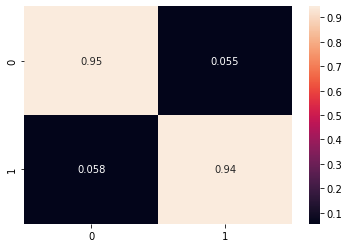

In [7]:
cm = confusion_matrix(normalize='true', y_pred=o, y_true=target)
sns.heatmap(cm, annot=True)
plt.show()

In [8]:
device = CudaDevice().get_device(force_cpu=False)

tokenizer = BertTokenizer.from_pretrained(BERT_MODEL_NAME)
model = torch.load("drive/MyDrive/Modelos/model_epoch_1.pt")
# Verifica a probabilidade da predição
# novo_texto = 'A entrega foi no prazo, as americanas estão de parabéns. A smart tv é muito boa, a navegação na internete e pelos aplicativos e excelente, não trava, sem falar da imagem que é de surpreender. recomendo.'
# novo_texto = 'não recomendo'
# novo_texto = 'péssima qualidade'
# novo_texto = 'não cumpre o que promete'
# novo_texto = 'tecido ruim'
# novo_texto = 'O produto é interessante mas não parece atender as minhas necessidades.'
# novo_texto = 'me arrependi'
# novo_texto = 'qualidade duvidosa'
# novo_texto = 'Não vi produto que atende tanto a minha necessidade.'
# novo_texto = 'Não vi produto que atende tão bem a minha necessidade.'
# novo_texto = 'Não encontrei problemas.'
# novo_texto = 'Não há reclamação.'
novo_texto = 'Não vi outro produto que atende tão bem a minha necessidade.'
# novo_texto = 'Nada demais.'
# novo_texto = 'péssimo atendimento.'
# novo_texto = '''
# Comprado de presente, decepcionado com a qualidade das tintas que recebeu o nome de Pentel, ficaria bem para uma criança
# mas não adianta para pintores mais sérios. O produto do vendedor chegou rapidamente bem embalado
# '''
# novo_texto = 'Produto chegou fora do prazo.'

model.eval()
with torch.no_grad():
  data = tokenizer.encode_plus(
    novo_texto,
    max_length=512,
    pad_to_max_length=True,
    add_special_tokens=True,
    return_attention_mask=True,
    return_token_type_ids=False,
    return_overflowing_tokens=False,
    truncation=True,
    return_tensors='pt')
  
  ids = data['input_ids'].to(device, dtype=torch.long)
  mask = data['attention_mask'].to(device, dtype=torch.long)

  otps = model(ids=ids, mask=mask)
  pred_proba = torch.softmax(otps, dim=1)

print(f'Predição = Neg({pred_proba[0][0]:0.4f}), Pos({pred_proba[0][1]:0.4f})')

Existe(m) 1 GPU(s) disponíveis.
A GPU Tesla P100-PCIE-16GB será usada.
Predição = Neg(0.2386), Pos(0.7614)
